In [1]:
from glob import glob

%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio

# add the unet helpers
sys.path.append('../')
from test_unet_helpers import *

# torch stuff
import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models, datasets
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

from glob import glob
class DG_GT_Dataset(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.img_files = glob(data_dir + '/dg*.tif')
        self.gt_files = glob(data_dir + '/gt*.tif')
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()

        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.img_files)

In [3]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

train_ds = DG_GT_Dataset(train_folder, channels='bgrn1')
test_ds = DG_GT_Dataset(test_folder, channels='bgrn1')
val_ds = DG_GT_Dataset(val_folder, channels='bgrn1')

# Now that data is ready, set up the model and run through it

## some code for saving the model

In [4]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

## some code for setting up the model and performance eval

In [5]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
# smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
#model = unet11_MS(num_bands=4, pretrained=False)

# set some parameters
lr = 0.0001
bsize = 4 # was 32
model = UNet(in_channels=4, n_classes=1, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=1.0)

###### specify DataLoaders
n_workers=0 # for some unknown reason, 0 is enabling all GPUs when 4 had previously done the trick. could be slower.
train_dl = DataLoader(train_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)
test_dl = DataLoader(test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
device=torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)
#     model.to(device)



print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0
# record time for one epoch
rocs = []

#####################################################

t0 = time.time()
num_epochs = 20
for epoch in range(num_epochs):
    
#     try:
    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    for i, (inputs_, targets_) in enumerate(train_dl):

        #print('hi')

        # get the inputs
        targets_ = targets_.type(torch.FloatTensor)

        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = model(inputs)

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1


        if i%5 == 0: # print/store every 10
            losses.append(i_loss)
            #running_loss += i_loss
            #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
        rocs.append(tu[1])


    losses_ep.append(losses)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

    # early exit critera
    if len(rocs)>2:
        if (np.abs(rocs[-1] - rocs[-2]) < 0.009) and (rocs[-1] > 0.98):
            print('area under curve not changing significantly, exit loop')
            break_flag = True
            break

#     except Exception as e:
#         print('something happened')
#         print(e)
#         break
        
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  4
training...
on epoch 1


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 1901.6289935112 seconds
on epoch 2
epoch: 2, LOSS=1.2024002075195312, ROC_AUC=0.7941871767814789 
time for epoch 2: 1751.1255531311035 seconds
on epoch 3


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 3: 1756.0018830299377 seconds
on epoch 4
epoch: 4, LOSS=0.8586452007293701, ROC_AUC=0.8848898171405957 
time for epoch 4: 1753.1798493862152 seconds
on epoch 5


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 5: 1767.4730014801025 seconds
on epoch 6
epoch: 6, LOSS=1.0149816274642944, ROC_AUC=0.847828405587947 
time for epoch 6: 1756.5172991752625 seconds
on epoch 7


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 7: 1762.512767314911 seconds
on epoch 8
epoch: 8, LOSS=0.7575259208679199, ROC_AUC=0.8915744902319067 
time for epoch 8: 1756.3023686408997 seconds
on epoch 9


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 9: 1762.1562323570251 seconds
on epoch 10
epoch: 10, LOSS=0.6912487745285034, ROC_AUC=0.8910325521457518 
time for epoch 10: 1757.3710765838623 seconds
on epoch 11


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 11: 1762.2994668483734 seconds
on epoch 12
epoch: 12, LOSS=0.7616283893585205, ROC_AUC=0.9043464317854258 
time for epoch 12: 1758.8598642349243 seconds
on epoch 13


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 13: 1764.4882338047028 seconds
on epoch 14
epoch: 14, LOSS=0.5426506996154785, ROC_AUC=0.9357377360542312 
time for epoch 14: 1757.6545202732086 seconds
on epoch 15


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 15: 1763.566009759903 seconds
on epoch 16
epoch: 16, LOSS=0.813345193862915, ROC_AUC=0.9047827446638994 
time for epoch 16: 1758.7396647930145 seconds
on epoch 17


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 17: 1763.4827020168304 seconds
on epoch 18
epoch: 18, LOSS=0.549557626247406, ROC_AUC=0.950812680529553 
time for epoch 18: 1758.1623311042786 seconds
on epoch 19


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 19: 1765.4832074642181 seconds
on epoch 20
epoch: 20, LOSS=0.54041588306427, ROC_AUC=0.945968536450027 
time for epoch 20: 1760.8050830364227 seconds
total time:  35337.83519887924


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


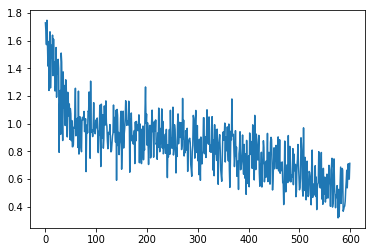

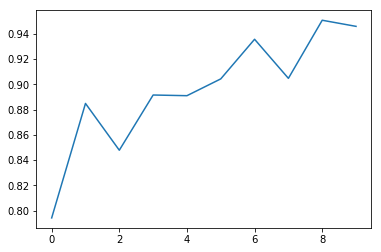

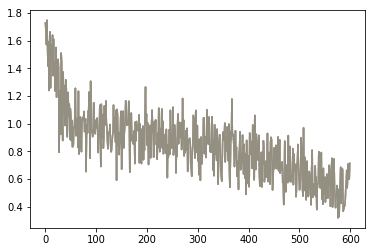

In [6]:
plt.plot(losses)
plt.show()

plt.plot(rocs)
plt.show()

plt.plot(np.array(losses_ep).T, alpha=0.1)
plt.show()

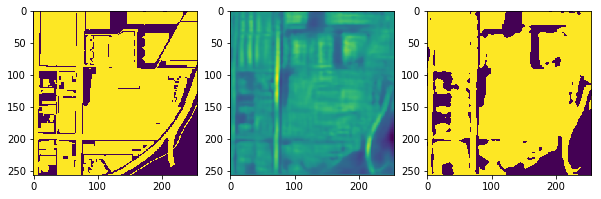

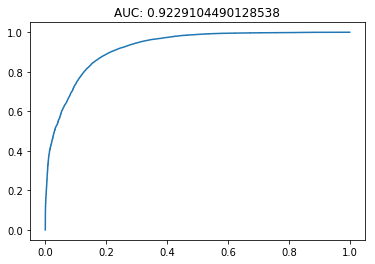

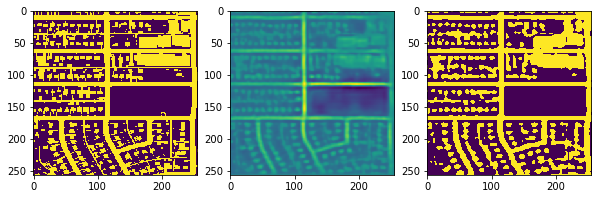

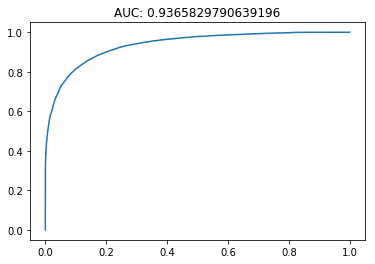

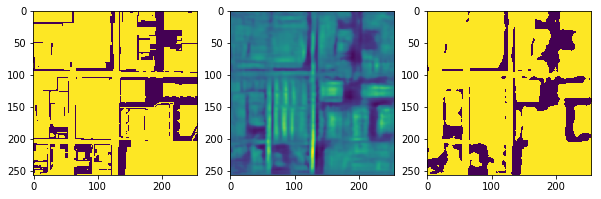

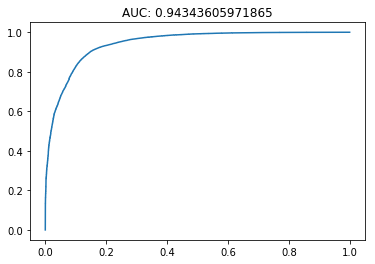

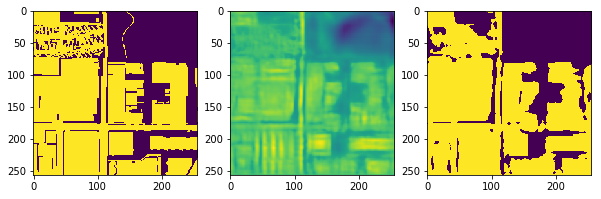

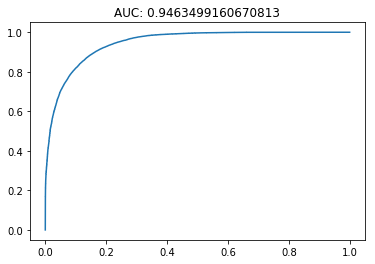

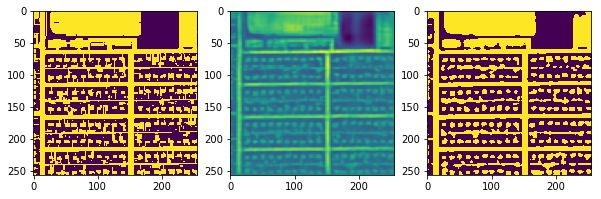

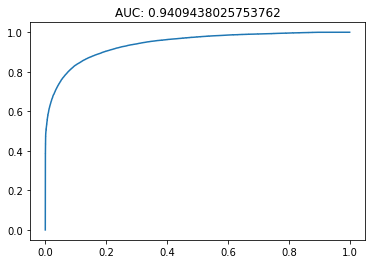

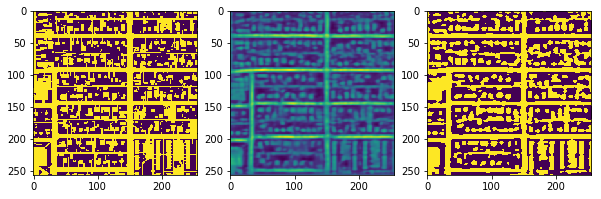

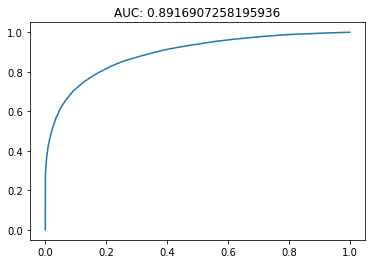

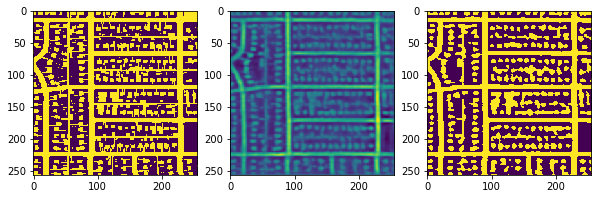

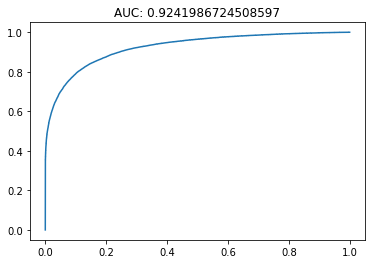

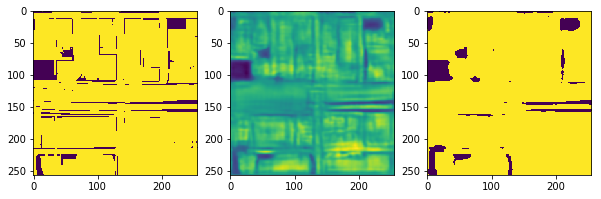

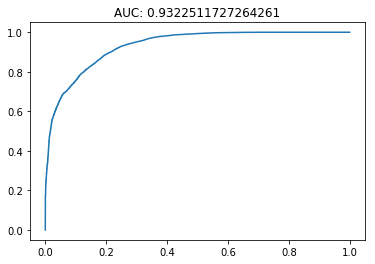

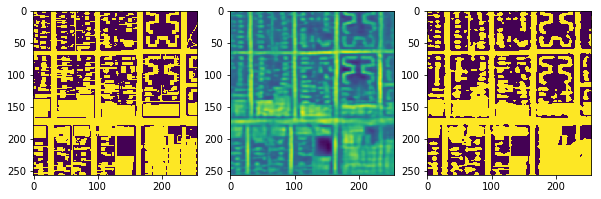

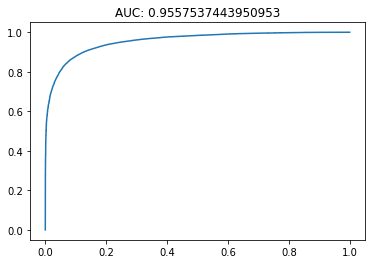

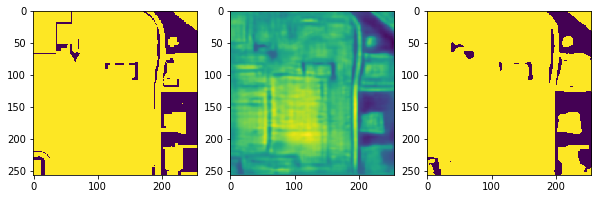

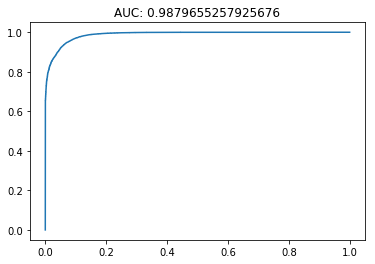

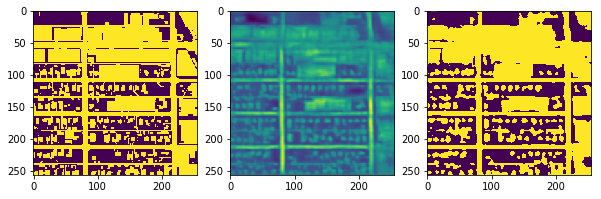

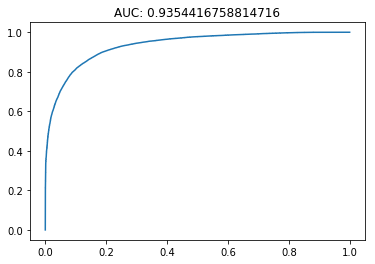

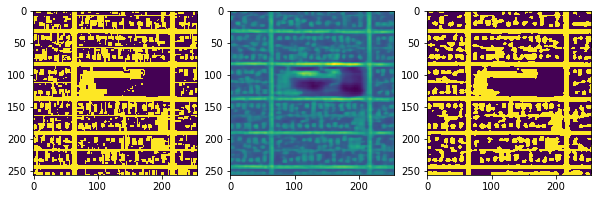

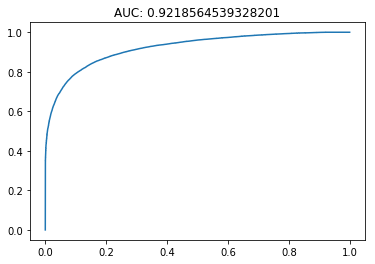

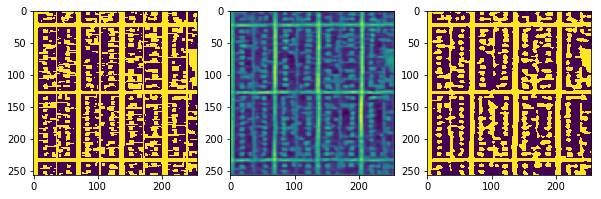

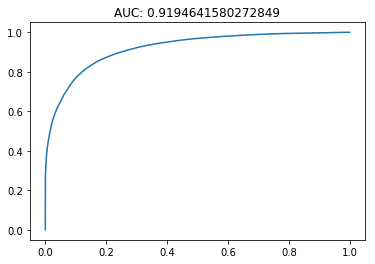

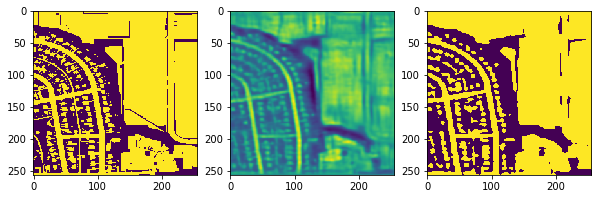

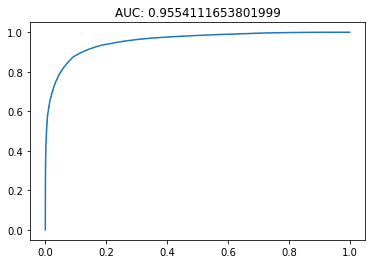

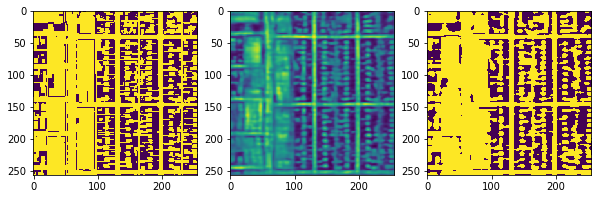

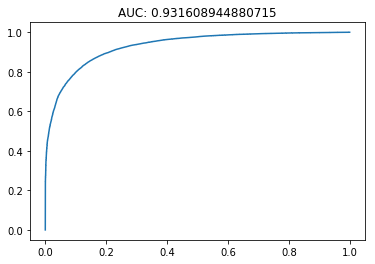

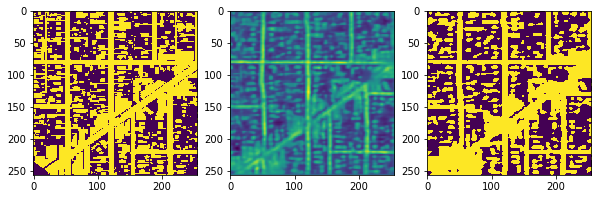

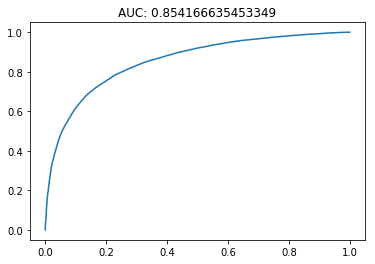

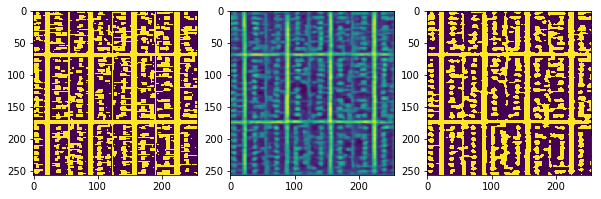

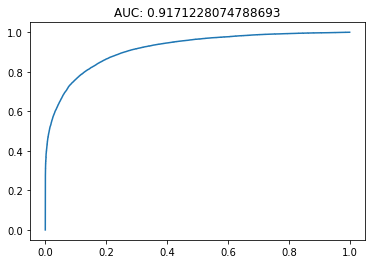

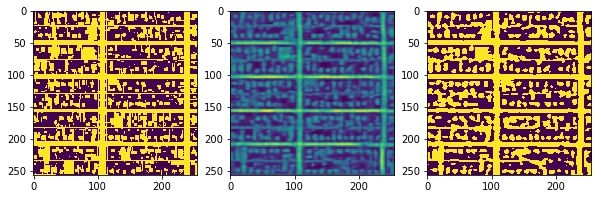

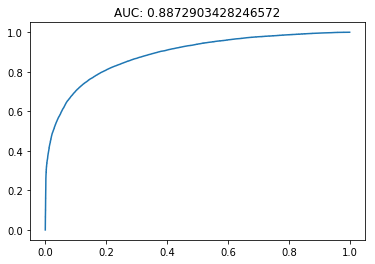

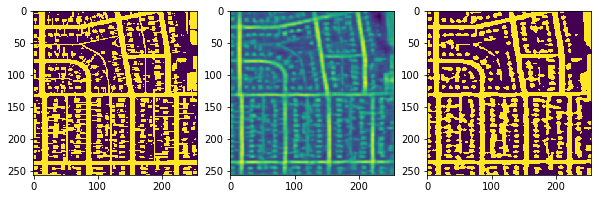

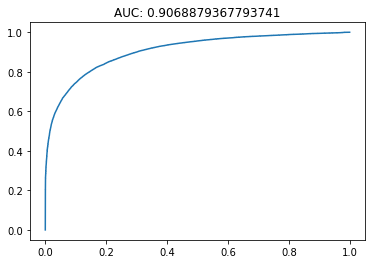

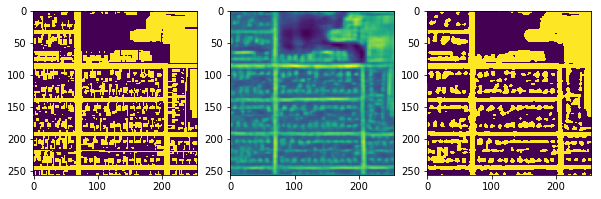

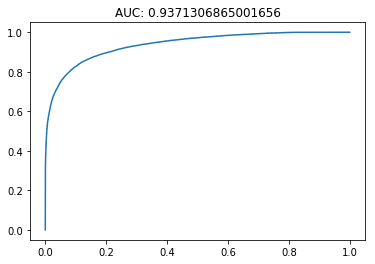

In [7]:
ind = 100
for ind in range(20):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = test_ds[ind]
    test_out = model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))


## save the model, AUC, and loss vectors

In [8]:
# directory
save_dir = 'files_bgrn1_SR10000'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# save the model
model_path = 'bgrn1_sr10000_ep{}_step{}_b{}.pt'.format(num_epochs, step, bsize)
model_path = os.path.join(save_dir, model_path)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(model_path)

# save the AUCs
auc_path = 'auc_bgrn1_sr10000_ep{}_step{}_b{}.txt'.format(num_epochs, step, bsize)
auc_path = os.path.join(save_dir, auc_path)
np.savetxt(auc_path, np.array(rocs))

#save the loss vectors
ep_loss_path = 'losses_ep_bgrn1_sr10000_ep{}_step{}_b{}.txt'.format(num_epochs, step, bsize)
ep_loss_path = os.path.join(save_dir, ep_loss_path)
np.savetxt(ep_loss_path, np.array(losses_ep))

#save the total loss vector
loss_path = 'loss_bgrn1_sr10000_ep{}_step{}_b{}.txt'.format(num_epochs, step, bsize)
loss_path = os.path.join(save_dir, loss_path)
np.savetxt(loss_path, np.array(losses))